In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
#In [2]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "images")

In [3]:
#In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if group_name in image_groups:
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "r")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in image_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
        xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "weights", "A-{:s}-{:s}-dot.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [4]:
#In [4]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 900 pos + 900 neg = 1800 total image triples
Generated 1656 pos + 1656 neg = 3312 total image triples


In [5]:
#In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

In [6]:
#In [6]:
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-vgg16-vectors.tsv")
print(VECTOR_FILE)
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

#In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb")) # Accuracy Score: 0.931
'''
Confusion Matrix
[[438   8]
 [ 61 487]]
'''
#In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm")) # Accuracy Score: 0.957
'''
Confusion Matrix
[[478  22]
 [ 21 473]]
'''
#In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb")) # Accuracy Score: 0.992
'''
Confusion Matrix
[[485   0]
 [  8 501]]
'''
#In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf")) # Accuracy Score: 0.985
'''
Confusion Matrix
[[482   4]
 [ 11 497]]
'''

weights/accton-vgg16-vectors.tsv


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2318, 4096) (994, 4096) (2318,) (994,)
fold 0, score: 0.961
fold 1, score: 0.953
fold 2, score: 0.914
fold 3, score: 0.957
fold 4, score: 0.940
fold 5, score: 0.897
fold 6, score: 0.918
fold 7, score: 0.905
fold 8, score: 0.909
fold 9, score: 0.935

Accuracy Score: 0.907

Confusion Matrix
[[423   9]
 [ 83 479]]

Classification Report
             precision    recall  f1-score   support

          0       0.84      0.98      0.90       432
          1       0.98      0.85      0.91       562

avg / total       0.92      0.91      0.91       994

fold 0, score: 0.953
fold 1, score: 0.931
fold 2, score: 0.931
fold 3, score: 0.948
fold 4, score: 0.944
fold 5, score: 0.931
fold 6, score: 0.966
fold 7, score: 0.931
fold 8, score: 0.948
fold 9, score: 0.978

Accuracy Score: 0.946

Confusion Matrix
[[481  29]
 [ 25 459]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.94      0.95       510
          1       0.94      0.95      0.94  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 1.000

Accuracy Score: 0.992

Confusion Matrix
[[498   0]
 [  8 488]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       498
          1       1.00      0.98      0.99       496

avg / total       0.99      0.99      0.99       994

fold 0, score: 0.991
fold 1, score: 0.978
fold 2, score: 0.983
fold 3, score: 0.987
fold 4, score: 0.987
fold 5, score: 0.978
fold 6, score: 0.996
fold 7, score: 0.991
fold 8, score: 0.974
fold 9, score: 0.991

Accuracy Score: 0.979

Confusion Matrix
[[497  12]
 [  9 476]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       509
          1       0.98      0.98      0.98       485

avg / total       0.98      0.98      0.98       994



' # images ## new_train_folder_test_v1\nConfusion Matrix\n[[482   4]\n [ 11 497]]\n'

In [7]:
#In [11]:
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-vgg19-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb")) # Accuracy Score: 0.915
'''
Confusion Matrix
[[450  12]
 [ 72 460]]
'''
#In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm")) # Accuracy Score: 0.949
'''
Confusion Matrix
[[477  21]
 [ 30 466]]
'''
#In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb")) # Accuracy Score: 0.996
'''
Confusion Matrix
[[503   0]
 [  4 487]]
'''
#In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf")) # Accuracy Score: 0.993
'''

'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2318, 4096) (994, 4096) (2318,) (994,)
fold 0, score: 0.905
fold 1, score: 0.935
fold 2, score: 0.927
fold 3, score: 0.927
fold 4, score: 0.914
fold 5, score: 0.944
fold 6, score: 0.905
fold 7, score: 0.922
fold 8, score: 0.939
fold 9, score: 0.913

Accuracy Score: 0.905

Confusion Matrix
[[428  15]
 [ 79 472]]

Classification Report
             precision    recall  f1-score   support

          0       0.84      0.97      0.90       443
          1       0.97      0.86      0.91       551

avg / total       0.91      0.91      0.91       994

fold 0, score: 0.935
fold 1, score: 0.957
fold 2, score: 0.922
fold 3, score: 0.922
fold 4, score: 0.914
fold 5, score: 0.935
fold 6, score: 0.948
fold 7, score: 0.931
fold 8, score: 0.935
fold 9, score: 0.948

Accuracy Score: 0.949

Confusion Matrix
[[477  21]
 [ 30 466]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       498
          1       0.96      0.94      0.95  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 1.000


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.991

Accuracy Score: 0.996

Confusion Matrix
[[503   0]
 [  4 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       503
          1       1.00      0.99      1.00       491

avg / total       1.00      1.00      1.00       994

fold 0, score: 0.983
fold 1, score: 0.978
fold 2, score: 0.991
fold 3, score: 0.991
fold 4, score: 0.983
fold 5, score: 0.970
fold 6, score: 0.991
fold 7, score: 0.991
fold 8, score: 0.983
fold 9, score: 0.991

Accuracy Score: 0.988

Confusion Matrix
[[502   7]
 [  5 480]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       509
          1       0.99      0.99      0.99       485

avg / total       0.99      0.99      0.99       994



' # images ## new_train_folder_test_v1\n\n'

In [8]:
#In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "weights", "accton-inception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb")) # Accuracy Score: 0.961
'''

'''
#In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm")) # Accuracy Score: 0.948
'''

'''
#In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb")) # Accuracy Score: 0.992
'''
Confusion Matrix
[[473   1]
 [  7 513]]
'''
#In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf")) # Accuracy Score: 0.973
'''
Confusion Matrix
[[492  16]
 [ 11 475]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2318, 2048) (994, 2048) (2318,) (994,)
fold 0, score: 0.944
fold 1, score: 0.978
fold 2, score: 0.970
fold 3, score: 0.987
fold 4, score: 0.961
fold 5, score: 0.953
fold 6, score: 0.978
fold 7, score: 0.966
fold 8, score: 0.961
fold 9, score: 0.983

Accuracy Score: 0.953

Confusion Matrix
[[488  32]
 [ 15 459]]

Classification Report
             precision    recall  f1-score   support

          0       0.97      0.94      0.95       520
          1       0.93      0.97      0.95       474

avg / total       0.95      0.95      0.95       994

fold 0, score: 0.909
fold 1, score: 0.961
fold 2, score: 0.961
fold 3, score: 0.966
fold 4, score: 0.944
fold 5, score: 0.944
fold 6, score: 0.935
fold 7, score: 0.935
fold 8, score: 0.965
fold 9, score: 0.939

Accuracy Score: 0.945

Confusion Matrix
[[463  15]
 [ 40 476]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       478
          1       0.97      0.92      0.95  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.983


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.991

Accuracy Score: 0.988

Confusion Matrix
[[493   2]
 [ 10 489]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       495
          1       1.00      0.98      0.99       499

avg / total       0.99      0.99      0.99       994

fold 0, score: 0.957
fold 1, score: 0.983
fold 2, score: 0.970
fold 3, score: 0.974
fold 4, score: 0.978
fold 5, score: 0.966
fold 6, score: 0.978
fold 7, score: 0.978
fold 8, score: 0.970
fold 9, score: 0.970

Accuracy Score: 0.973

Confusion Matrix
[[492  16]
 [ 11 475]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.97      0.97       508
          1       0.97      0.98      0.97       486

avg / total       0.97      0.97      0.97       994



' # images ## new_train_folder_test_v1\nConfusion Matrix\n[[468  24]\n [ 12 490]]\n'

In [9]:
#In [21]:
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-resnet-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb")) # Accuracy Score: 0.937
'''
Confusion Matrix
[[463  29]
 [ 34 468]]
'''
#In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm")) # Accuracy Score: 0.938
'''
Confusion Matrix
[[459  14]
 [ 48 473]]
'''
#In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb")) # Accuracy Score: 0.993
'''
Confusion Matrix
[[490   0]
 [  7 497]]
'''
#In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf")) # Accuracy Score: 0.982
'''
Confusion Matrix
[[488   9]
 [  9 488]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2318, 2048) (994, 2048) (2318,) (994,)
fold 0, score: 0.922
fold 1, score: 0.948
fold 2, score: 0.914
fold 3, score: 0.944
fold 4, score: 0.953
fold 5, score: 0.918
fold 6, score: 0.948
fold 7, score: 0.948
fold 8, score: 0.944
fold 9, score: 0.926

Accuracy Score: 0.914

Confusion Matrix
[[466  44]
 [ 41 443]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.91      0.92       510
          1       0.91      0.92      0.91       484

avg / total       0.91      0.91      0.91       994

fold 0, score: 0.914
fold 1, score: 0.931
fold 2, score: 0.953
fold 3, score: 0.957
fold 4, score: 0.944
fold 5, score: 0.961
fold 6, score: 0.966
fold 7, score: 0.940
fold 8, score: 0.922
fold 9, score: 0.952

Accuracy Score: 0.938

Confusion Matrix
[[459  14]
 [ 48 473]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.97      0.94       473
          1       0.97      0.91      0.94  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.966


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.983


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.987

Accuracy Score: 0.989

Confusion Matrix
[[496   0]
 [ 11 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       496
          1       1.00      0.98      0.99       498

avg / total       0.99      0.99      0.99       994

fold 0, score: 0.974
fold 1, score: 0.970
fold 2, score: 0.978
fold 3, score: 0.983
fold 4, score: 0.983
fold 5, score: 0.991
fold 6, score: 0.974
fold 7, score: 0.991
fold 8, score: 0.970
fold 9, score: 0.978

Accuracy Score: 0.978

Confusion Matrix
[[498  13]
 [  9 474]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       511
          1       0.97      0.98      0.98       483

avg / total       0.98      0.98      0.98       994



' # images ## new_train_folder_test_v1\nConfusion Matrix\n[[488   9]\n [  9 488]]\n'

In [10]:
#In [26]:
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-xception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)
#In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb")) # Accuracy Score: 0.949
'''
Confusion Matrix
[[456  31]
 [ 20 487]]
'''
#In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm")) # Accuracy Score: 0.968
'''
Confusion Matrix
[[490  12]
 [ 20 472]]
'''
#In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb")) # Accuracy Score: 0.997
'''
Confusion Matrix
[[508   1]
 [  2 483]]
'''
#In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf")) # Accuracy Score: 0.980
'''
Confusion Matrix
[[495   5]
 [ 15 479]]
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(2318, 2048) (994, 2048) (2318,) (994,)
fold 0, score: 0.935
fold 1, score: 0.940
fold 2, score: 0.978
fold 3, score: 0.953
fold 4, score: 0.944
fold 5, score: 0.957
fold 6, score: 0.948
fold 7, score: 0.974
fold 8, score: 0.952
fold 9, score: 0.931

Accuracy Score: 0.937

Confusion Matrix
[[485  38]
 [ 25 446]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.93      0.94       523
          1       0.92      0.95      0.93       471

avg / total       0.94      0.94      0.94       994

fold 0, score: 0.966
fold 1, score: 0.961
fold 2, score: 0.996
fold 3, score: 0.970
fold 4, score: 0.970
fold 5, score: 0.974
fold 6, score: 0.978
fold 7, score: 0.948
fold 8, score: 0.965
fold 9, score: 0.970

Accuracy Score: 0.968

Confusion Matrix
[[490  12]
 [ 20 472]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       502
          1       0.98      0.96      0.97  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.987


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.983


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.996


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.991


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 9, score: 0.983

Accuracy Score: 0.997

Confusion Matrix
[[508   1]
 [  2 483]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       509
          1       1.00      1.00      1.00       485

avg / total       1.00      1.00      1.00       994

fold 0, score: 0.974
fold 1, score: 0.978
fold 2, score: 0.970
fold 3, score: 0.987
fold 4, score: 0.961
fold 5, score: 0.974
fold 6, score: 0.983
fold 7, score: 0.987
fold 8, score: 0.983
fold 9, score: 0.978

Accuracy Score: 0.980

Confusion Matrix
[[495   5]
 [ 15 479]]

Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       500
          1       0.99      0.97      0.98       494

avg / total       0.98      0.98      0.98       994



' # images ## new_train_folder_test_v1\nConfusion Matrix\n[[464   8]\n [ 12 510]]\n'

Text(0.5,1,'element-wise dot product of vectors')

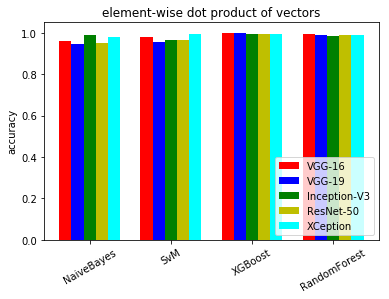

In [12]:
#In [31]:
scores
#In [32]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("element-wise dot product of vectors")